**Subgroup B Question 1**

**How can we accurately predict individual customer preferences and needs?**

- Develop a recommendation system to suggest relevant products and services.
- Identify key factors influencing customer preferences

In [90]:
# Libraries
import os
import numpy as np
import pandas as pd
from pandas.api.types import is_object_dtype

In [91]:
# Load the data
# Helper function
def load_data(filename):
    '''load the data with only filename'''
    return pd.read_csv(os.path.join(PATH, filename))

# Set path 
parent_directory = os.path.abspath(os.path.join('..'))
PATH = os.path.join(parent_directory, 'data')

# Load dataset
df = load_data('final_dataset.csv')

### Data Cleaning

#### Conversion of ordinal data types with 'Unknown' values
Data is converted to the appropriate data type for data transformation and feature selection. Since many models are unable to deal with non-numerical data, categorical data must be converted to an appropriate data type via methods such as label encoding (only for ordinal variables) and one-hot encoding.

As there are individuals marked 'Unknown' in some ordinal variables (Education_Level and Income_Category), some decisions must be made on how to handle them since ordinal variables are ranked. 

While the collection method is not known, the assumption has been made that demographic data for Education_Level and Income_Category are obtained through methods such as transactions, credited salary to a bank account, loan applications and the likes. As these processes are usually automated or likely to be meticulously documented (banks are likely to have proper SOP in place that makes it highly unlikely that the data was not documented, particularly since stakes are high), and thus the data is not likely to be missing completely at random. It is more likely that these individuals with variables marked 'Unknown' have not engaged with any products and services offered by the bank, and thus the bank does not have any data on these individuals. 

As the segmentation model does not consider rows with variables marked 'Unknown' at all, for consistency, they will be dropped as well.

#### Target variables
All the original product columns have integers values representing what service or product tier the customer is currently paying for. As the recommendation system would recommend what products and not what tier users should get, the product columns will be turned into binary in the following manner:

**0**: The customer does not have the product\
**1**: The customer has the product

There are some products where all customers have the product (perhaps something like a savings account), and thus in those cases:

**0**: The customer has the lowest tier of the product\
**1**: The customer has an upgraded version of the product

In [92]:
# Remove Unknown 
df1 = df.drop(columns='Unnamed: 0')
df1 = df1[~df1.isin(['Unknown']).any(axis=1)]

# Convert into appropriate data type
levels = {
    'Education_Level': ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'],
    'Income_Category': ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'],
    'Attrition_Flag': ['Existing Customer', 'Attrited Customer'],
    'Card_Category': ['Blue', 'Silver', 'Gold', 'Platinum']
}
categorical = {
    'Marital_Status': ['Married', 'Single', 'Divorced']
}

for col in df1.columns:
    if is_object_dtype(df1[col]):
        if col in levels.keys():
            '''
            if 'Unknown' in df[col].unique():
                # Keep track of columns with imputed values
                df1[f"{col}_NA"] = df1[col].eq('Unknown').astype(int)
                
                # Impute 'Unknown' values with the mode of the column
                mode_value = df1[col].mode()[0]
                df1[col] = df1[col].replace('Unknown', mode_value)'''
            
             # Label encoding
            df1[col] = pd.Categorical(df1[col], categories=levels[col], ordered=True)
            df1[col] = df1[col].cat.codes

# One hot encoding
df1 = pd.get_dummies(df1)

df1.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,A,B,C,D,E,F,G,risk_factor,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
0,768805383,0,45,3,1,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,2,0,1,2,0,2,1,1,False,True,False,True,False
1,818770008,0,49,5,3,0,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1,0,4,3,1,0,2,3,True,False,False,False,True
2,713982108,0,51,3,3,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,0,1,3,0,0,4,4,False,True,False,True,False
4,709106358,0,40,3,0,2,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1,1,1,3,1,0,2,2,False,True,False,True,False
5,713061558,0,44,2,3,1,0,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,2,1,2,3,1,1,1,2,False,True,False,True,False


In [93]:
df1.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Dependent_count',
       'Education_Level', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'A',
       'B', 'C', 'D', 'E', 'F', 'G', 'risk_factor', 'Gender_F', 'Gender_M',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single'],
      dtype='object')

In [94]:
# Convert products into binary 
product_list = set(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
features_list = list(set(df1.columns).difference(product_list))
features_list.remove('CLIENTNUM')

df2 = df1
for product in product_list:
    # Since minimum is 1, the recommendation would be based on whether an upgrade should be recommended
    if product in ['C', 'D', 'G']:
        df2[product] = np.where(df2[product] > 1, 1, 0)
    # Some users do not have this product at all
    else:
        df2[product] = np.where(df2[product] > 0, 1, 0)

product_list = list(product_list)
product_list.sort()

### EDA: Identify key features
There are many columns, and not all of them are relevant. Including them all would cause an unnecessary increase in the input dimension, which makes it difficult for the model to identify relevant relationships, among other issues.

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression

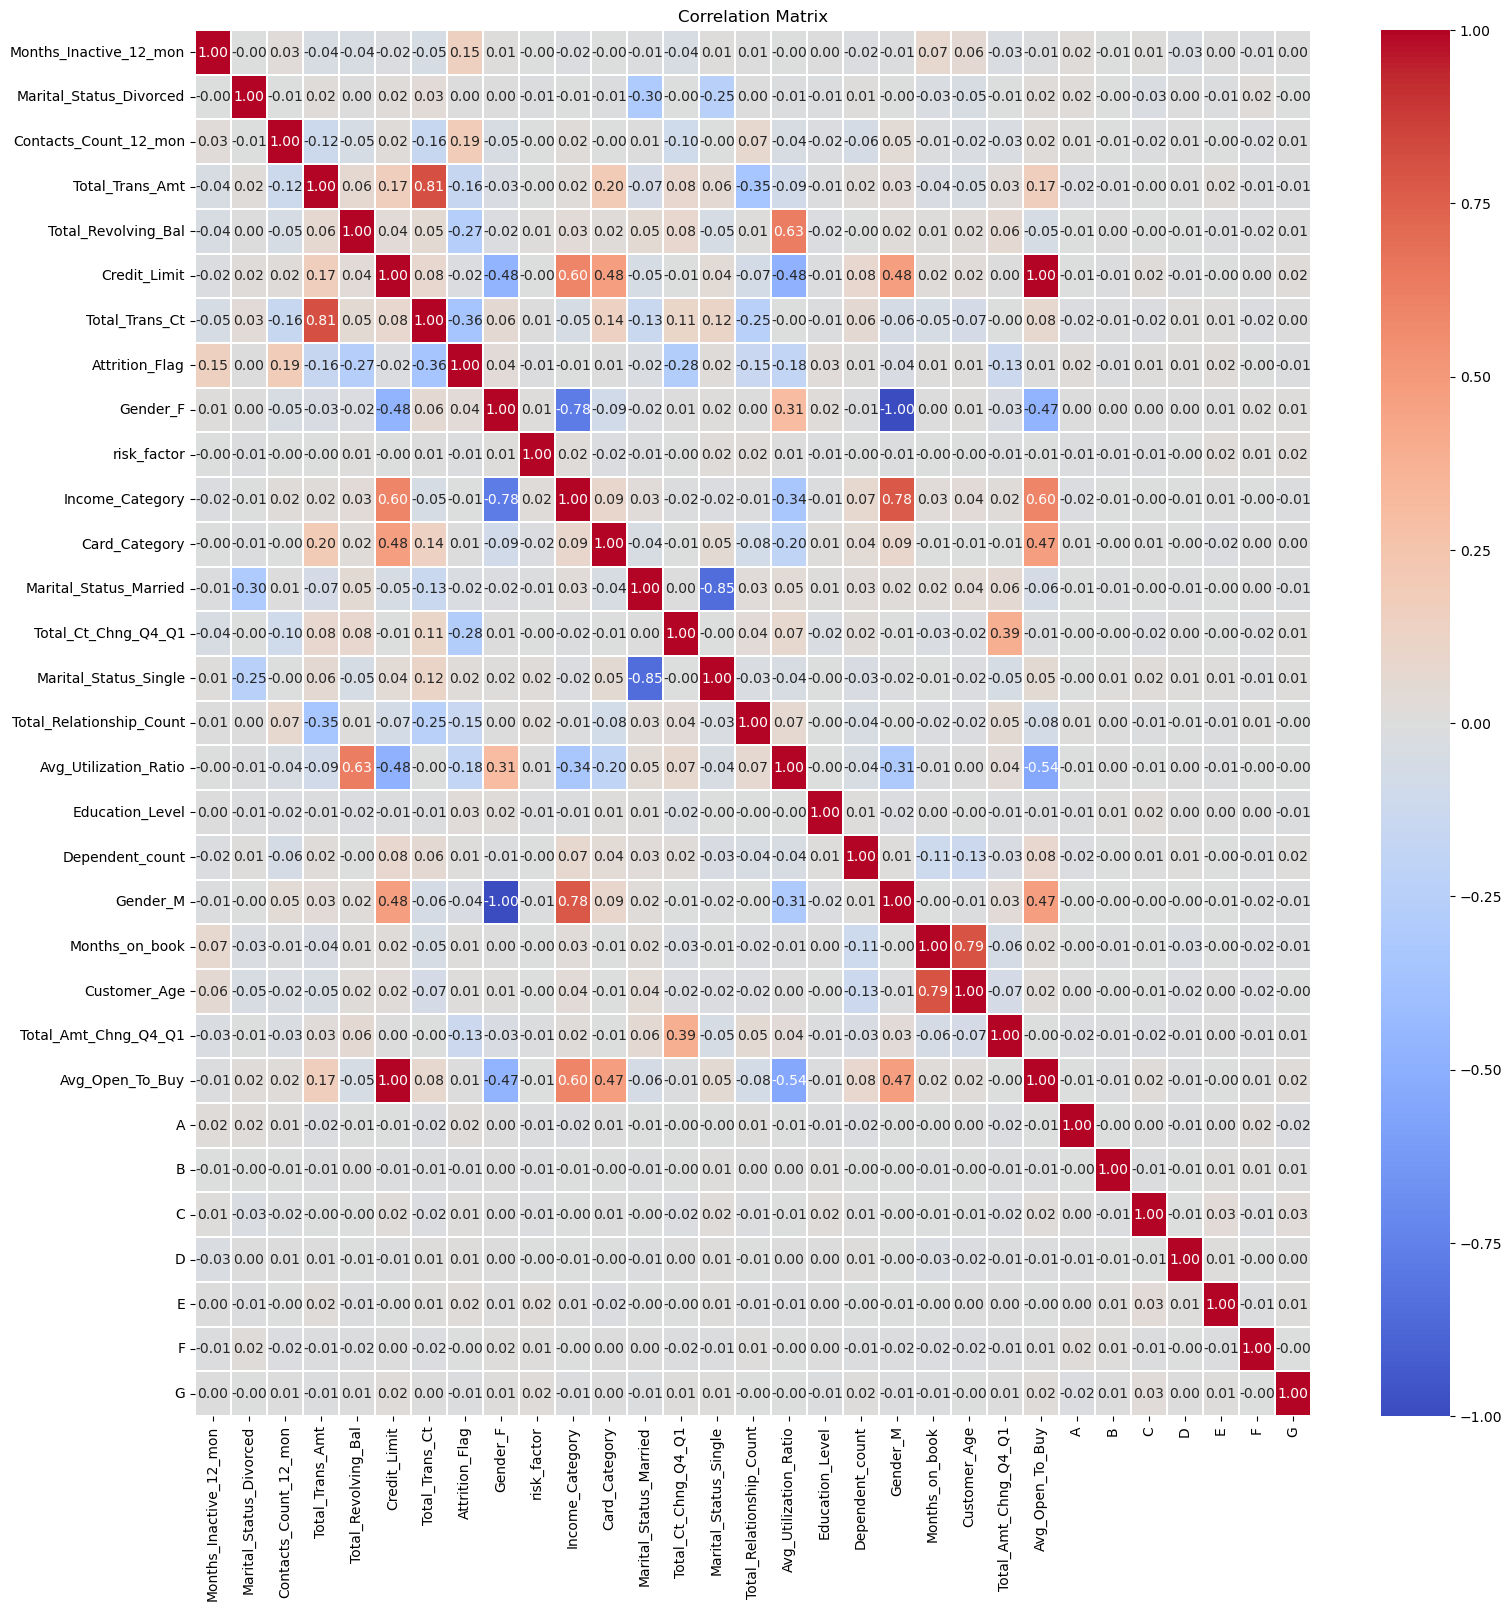

In [97]:
# Examine correlation
correlation_matrix = df2[features_list+list(product_list)].corr()

plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.1)
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix, it can be seen that...(continue)

In [98]:
# Choose the best features
def select_best(x, y):
    KBest = SelectKBest(score_func = f_regression, k = 10)
    KBest = KBest.fit(x, y)

    cols = KBest.get_support(indices=True)
    cols = x.columns[cols]

    return list(cols), pd.DataFrame({'features': x.columns, 'score': KBest.scores_, 'p-value': KBest.pvalues_ })

scores = {}
cols = {}
for product in product_list:
    X = df2.drop(columns=[product, 'CLIENTNUM'])
    cols[product], scores[product] = select_best(X, df2[product])
    

In [99]:
cols['A']

['Attrition_Flag',
 'Dependent_count',
 'Income_Category',
 'Months_Inactive_12_mon',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'F',
 'G',
 'Marital_Status_Divorced']

In [100]:
scores['A']

,features,score,p-value
0,Attrition_Flag,2.437297,0.118525
1,Customer_Age,0.002863,0.957328
2,Dependent_count,2.106189,0.146749
3,Education_Level,1.319825,0.250662
4,Income_Category,2.894120,0.088947
5,Card_Category,0.223212,0.636618
6,Months_on_book,0.022538,0.880669
7,Total_Relationship_Count,1.388462,0.238705
8,Months_Inactive_12_mon,2.870126,0.090282
9,Contacts_Count_12_mon,1.173616,0.278696


#### Model training and testing
As the dataset contains many categorical variables and the problem is a classification one, decision tree architectures such as XGBoost can be utilised. Since XGBoost utilises decision trees, normalising/standardising is not required. 

Other more common methods such as collaborative filtering, which recommends users products based on the similarities in demographics, can also be utilised.

In [ ]:
# libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

In [ ]:
# XGBoost implementation
train = {}
predicted_labels = {}
actual_labels = {}

for i in product_list:
    y = df2[i]
    train[product] = df2[cols[product] + ['CLIENTNUM']]
    train[product] = train[product].set_index('CLIENTNUM')
    
    X_train, X_test, y_train, y_test = train_test_split(train[product], y, test_size=0.4, random_state=123)

    bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
    bst.fit(X_train.to_numpy(), y_train.to_numpy())
    
    # Get features from GBDT for training Logistic Regression
    features = bst.apply(X_train.to_numpy())
    
    lr_model = LogisticRegression(max_iter=2000, C=0.5, random_state=123)
    lr_model.fit(features, y_train.to_numpy())
    
    # Generate GBDT features for testing set and predict with Logistic Regression
    gbdt_features_test = bst.apply(X_test.to_numpy())
    lr_features = lr_model.predict_proba(gbdt_features_test)[:, 1]
    
    predicted_labels[i] = lr_features
    actual_labels[i] = y_test


In [103]:
def get_results(results, x):
    r = pd.DataFrame(results)
    df = pd.concat([x.reset_index(names = 'CLIENTNUM'), r], axis = 1, ignore_index = True)

    col_list = ['CLIENTNUM'] + list(x.columns) + list(r.columns)
    df.columns = col_list
    
    return df[['CLIENTNUM'] + list(r.columns)]

In [ ]:
# Prediction
pldf = get_results(predicted_labels, X_test.drop(columns=[c for c in product_list if c in X_test.columns]))
pldf = pldf.set_index('CLIENTNUM')
pldf = pldf.apply(lambda x: np.where(x > 0.65, 1, 0))

pldf.head(5)

,A,B,C,D,E,F,G
CLIENTNUM,,,,,,,
713208033,1,0,1,1,0,1,1
714726858,1,0,0,1,0,1,1
789191358,0,0,0,1,0,1,1
779601783,1,0,0,1,0,1,1
711786108,1,0,1,1,0,1,1


### Save predictions for API call


In [ ]:
pldf.to_csv("BQ1")

### Evaluation
Evaluation metrics used:\
*Standard performance metrics*
- Confusion matrix
- F1 score
*Specific evaluation metrics*


In [105]:
# Libraries
from sklearn.metrics import accuracy_score, confusion_matrix

In [106]:
# Get actual labels
aldf = pd.DataFrame(actual_labels)
aldf.head(5)

,A,B,C,D,E,F,G
8685,1,0,1,1,0,1,1
4999,1,0,0,0,0,1,0
7837,0,1,0,1,0,1,1
3487,1,0,0,1,1,1,0
2072,1,1,1,1,1,1,1


In [107]:
# Get accuracy
confusion_matrixes = {}
accuracy = {}
for col in aldf.columns:
    confusion_matrixes[col] = confusion_matrix(aldf[col], pldf[col])
    accuracy[col] = accuracy_score(aldf[col], pldf[col])


In [108]:
# the count of true negatives is C00, false negatives is C10, true positives is C11 and false positives is C01
confusion_matrixes

{'A': array([[1024,    0],
        [   0, 1809]], dtype=int64),
 'B': array([[1431,    0],
        [1402,    0]], dtype=int64),
 'C': array([[ 856,    0],
        [   0, 1977]], dtype=int64),
 'D': array([[   0,  599],
        [   0, 2234]], dtype=int64),
 'E': array([[1468,   11],
        [1348,    6]], dtype=int64),
 'F': array([[   3,  893],
        [  23, 1914]], dtype=int64),
 'G': array([[   0,  791],
        [   0, 2042]], dtype=int64)}

In [109]:
accuracy

{'A': 1.0,
 'B': 0.505118249205789,
 'C': 1.0,
 'D': 0.7885633603953406,
 'E': 0.520296505471232,
 'F': 0.6766678432756795,
 'G': 0.7207906812566184}